Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# FLAML Specified Search Space

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

from flaml import AutoML
from flaml.data import get_output_from_log
from flaml.model import LGBMEstimator, BaseEstimator
from flaml import tune

import flaml
print(flaml.__version__)

0.5.11


In [2]:
df30 = pd.read_csv('../../crystal_ball/data_collector/structured_data/leaf.csv')
print(df30.shape)

df30.head()

(340, 16)


,species,specimen_number,eccentricity,aspect_ratio,elongation,solidity,stochastic_convexity,isoperimetric_factor,maximal_indentation_depth,lobedness,average_intensity,average_contrast,smoothness,third_moment,uniformity,entropy
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.83592,0.004657,0.003947,0.047790,0.127950,0.016108,0.005232,0.000275,1.17560
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.79867,0.005242,0.005002,0.024160,0.090476,0.008119,0.002708,0.000075,0.69659
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.80812,0.007457,0.010121,0.011897,0.057445,0.003289,0.000921,0.000038,0.44348
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.81697,0.006877,0.008607,0.015950,0.065491,0.004271,0.001154,0.000066,0.58785
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.75493,0.007428,0.010042,0.007938,0.045339,0.002051,0.000560,0.000024,0.34214


In [3]:
# train, test split for df30
y30 = df30['species']
X30 = df30.drop('species', axis=1)

X_train30, X_test30, y_train30, y_test30 = train_test_split(X30, y30, test_size=0.2,
                                               random_state=10, shuffle=True, stratify=y30)

X_train30.reset_index(inplace=True, drop=True)
X_test30.reset_index(inplace=True, drop=True)
y_train30.reset_index(inplace=True, drop=True)
y_test30.reset_index(inplace=True, drop=True)

print(X_train30.shape, X_test30.shape, y_train30.shape, y_test30.shape)
print(y_train30.nunique(), y_test30.nunique())

(272, 15) (68, 15) (272,) (68,)
30 30


In [4]:
def plot_learning_curve(training_time_list,  best_error_list):
    plt.title('Learning Curve')
    plt.xlabel('Training Time (s)')
    plt.ylabel('Best Validation Loss')
    plt.scatter(training_time_list,  best_error_list)
    plt.step(training_time_list, best_error_list, where='post')
    plt.show()

## Customize LGBM for Leaves30

* LGBM is included in FLAML's estimator list
  * Find all the estimators in `flaml.model`:https://github.com/microsoft/FLAML/blob/main/flaml/model.py
  * LGBM's default search space in FLAML: https://github.com/microsoft/FLAML/blob/main/flaml/model.py#L199
* LGBM params: https://lightgbm.readthedocs.io/en/latest/Parameters.html
  * Tips for LGBM param tuning: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
  * `tune` API search space functions: https://docs.ray.io/en/master/tune/api_docs/search_space.html
* You can inherit from either `BaseEstimator` or `LGBMEstimator`
  * If your customized estimator is inherted from BaseEstimator, it might be time consuming to resolve errors caused by FLAML specific parameters. But if you inherit from a built-in FLAML estimator such as `LGBMEstimator`, you will get unwanted estimator params, and the way to ignore them is to keep them in `search_space()` and set them as None in `__init__()`, this is odd and less efficient, but might be a simple solution...
  * Better to have `super().__init__(**params)` in `__init__()` inhert params from the super class
    * If you want to add/remove params for the customized estimator, you can specify it in `self.params` after using `super().__init__(**params)`
    * You can also directly add params in `search_space()` without specifying them in `self.params` under `__init__()`

In [99]:
class my_lgbm(LGBMEstimator):
    
    def __init__(self, **params):
        super().__init__(**params)
        
        if "min_child_samples" in self.params:
            self.params["min_child_samples"] = None  # set as None to remove the param from the estimator
        
    @classmethod
    def search_space(cls, data_size, **params):
        upper = min(32768, int(data_size))
        return {
            'n_estimators': {'domain': tune.lograndint(lower=4, upper=upper), 'init_value': 4, 'low_cost_init_value': 4},
            'num_leaves': {'domain': tune.lograndint(lower=4, upper=upper), 'init_value': 4, 'low_cost_init_value': 4},
            'min_child_samples': {'domain': tune.lograndint(lower=2, upper=2**7), 'init_value': 20},  # ignored param but has to appear here
            'learning_rate': {'domain': tune.loguniform(lower=1 / 1024, upper=1.0), 'init_value': 0.1},
            'subsample': {'domain': tune.uniform(lower=0.1, upper=1.0), 'init_value': 1.0},
            'log_max_bin': {'domain': tune.lograndint(lower=3, upper=10), 'init_value': 8},
            'colsample_bytree': {'domain': tune.uniform(lower=0.01, upper=1.0), 'init_value': 1.0},
            'reg_alpha': {'domain': tune.loguniform(lower=1 / 1024, upper=1024), 'init_value': 1 / 1024},
            'reg_lambda': {'domain': tune.loguniform(lower=1 / 1024, upper=1024), 'init_value': 1.0},
            'max_depth': {'domain': tune.lograndint(lower=2, upper=upper), 'init_value': 7, 'low_cost_init_value': 7},
            'min_data_in_leaf': {'domain': tune.lograndint(lower=2, upper=upper), 'init_value': 50, 'low_cost_init_value': 50},
            'extra_trees': {'domain': True, 'init_value': True, 'low_cost_init_value': True},
        }

In [100]:
np.random.seed(10)  # To make sure same code will get the same output from FLAML

automl30 = AutoML()

settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": 'accuracy', 
    "task": 'multi',  # multiclass classification
    "n_splits": 5,
    "estimator_list": ['my_lgbm'],
    "split_type": 'stratified',
    "verbose": 0,
    "log_file_name": 'logs/automl_specified_space_leaf30.log',  # flaml log file
}

automl30.add_learner(learner_name='my_lgbm', learner_class=my_lgbm)
automl30.fit(X_train=X_train30, y_train=y_train30, **settings)

Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 9 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 7 iterations
Finished loading model, total used 11 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 24 iterations
Finished loading model, total used 43 iterations
Finished loading model, total used 13 iterations
Finished loading model, total used 39 iterations
Finished loading model, total used 15 iterations
Finished loading model, total used 20 iterations
Finished loading model, total used 29 iterations
Finished loading model, total used 72 iterations
Finished loading model, total used 12 iterations
Finished loading model, total used 33 iterations
Finished loading model, total used 25 iterations
Finished loading model, total used 16 iterations
Finished loading model, tot

Selected Estimator: LGBMClassifier(colsample_bytree=0.9933542087718672, extra_trees=True,
               learning_rate=0.27722037570044883, max_bin=256, max_depth=2,
               min_child_samples=None, min_data_in_leaf=2, n_estimators=103,
               num_leaves=6, objective='multiclass', reg_alpha=0.0009765625,
               reg_lambda=3.510335350081705, subsample=0.8190037325161851)
Best loss on validation data: 0.005614
Training duration of best run: 4.07 s

The balanced accuracy on testing data from optimized model is 0.8388888888888888


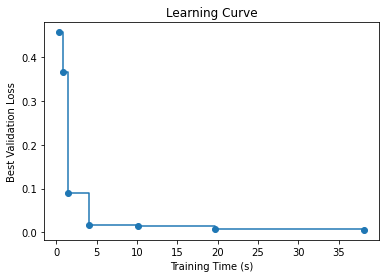

In [101]:
print('Selected Estimator:', automl30.model.estimator)
print('Best loss on validation data: {0:.4g}'.format(automl30.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl30.best_config_train_time))
print()

y_pred30 = automl30.predict(X_test30)
balanced_accuracy = balanced_accuracy_score(y_test30, y_pred30)
print(f'The balanced accuracy on testing data from optimized model is {balanced_accuracy}')

# save the optimized automl object
with open('trained_models/automl_specified_space_leaf30.pkl', 'wb') as f:
    pickle.dump(automl30, f, pickle.HIGHEST_PROTOCOL)
    
    
# plot FLAML learning curve
training_time_list, best_error_list, error_list, config_list, logged_metric_list = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=60)

plot_learning_curve(training_time_list, best_error_list)

## CFO vs BlendSearch in Larger Search Space for Leaves30

* Larger search space
  * Added `path_smooth`, `max_bin`, `bagging_freq`, increased `min_data_in_leaf`. 
    * These were supposed to reduce overfitting and increase accuracy
    * Validation loss reducted from 0.005614 to 0.002817 but the testing results dropped from 0.84 to 0.7. 
  * CFO is still faster than BlendSearch without sacrificing the testing performance in this case

* BS doesn't recognize all the legal LGBM params, such as `extra_trees`

In [102]:
class my_lgbm(LGBMEstimator):
    
    def __init__(self, **params):
        super().__init__(**params)
        
        if "min_child_samples" in self.params:
            self.params["min_child_samples"] = None   
        if "subsample_freq" in self.params:
            self.params["subsample_freq"] = None
            
        
    @classmethod
    def search_space(cls, data_size, **params):
        upper = min(32768, int(data_size))
        return {
            'n_estimators': {'domain': tune.lograndint(lower=4, upper=upper), 'init_value': 4, 'low_cost_init_value': 4},
            'num_leaves': {'domain': tune.lograndint(lower=4, upper=upper), 'init_value': 4, 'low_cost_init_value': 4},
            'min_child_samples': {'domain': tune.lograndint(lower=2, upper=2**7), 'init_value': 20},  # ignored param (because of `min_data_in_leaf`) but has to appear here
            'learning_rate': {'domain': tune.loguniform(lower=1 / 1024, upper=1.0), 'init_value': 0.1},
            'subsample': {'domain': tune.uniform(lower=0.1, upper=1.0), 'init_value': 1.0},  # same as `bagging_fraction`
            'log_max_bin': {'domain': tune.lograndint(lower=3, upper=10), 'init_value': 8},
            'colsample_bytree': {'domain': tune.uniform(lower=0.01, upper=1.0), 'init_value': 1.0},  # same as `feature_fraction`
            'reg_alpha': {'domain': tune.loguniform(lower=1 / 1024, upper=1024), 'init_value': 1 / 1024},
            'reg_lambda': {'domain': tune.loguniform(lower=1 / 1024, upper=1024), 'init_value': 1.0},
            'max_depth': {'domain': tune.lograndint(lower=2, upper=upper), 'init_value': 7, 'low_cost_init_value': 7},
            'min_data_in_leaf': {'domain': tune.randint(lower=2, upper=upper), 'init_value': 50, 'low_cost_init_value': 50},
            'path_smooth': {'domain': tune.randint(lower=0, upper=10), 'init_value': 0, 'low_cost_init_value': 0},
            'max_bin': {'domain': tune.randint(lower=240, upper=500), 'init_value': 255, 'low_cost_init_value': 255},
            'bagging_freq': {'domain': tune.randint(lower=0, upper=5), 'init_value': 0},
            'subsample_freq': {'domain': tune.randint(lower=0, upper=5), 'init_value': 0} # ignored param (because of `bagging_freq`) but has to appear here
        }

### CFO

Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 5 iterations
Finished loading model, total used 11 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 6 iterations
Finished loading model, total used 8 iterations
Finished loading model, total used 5 iterations
Finished loading model, total used 15 iterations
Finished loading model, total used 6 iterations
Finished loading model, total used 14 iterations
Finished loading model, total used 16 iterations
Finished loading model, total used 24 iterations
Finished loading model, total used 9 iterations
Finished loading model, total used 8 iterations
Finished loading model, total used 28 iterations
Finished loading model, total used 22 iterations
Finished loading model, total use

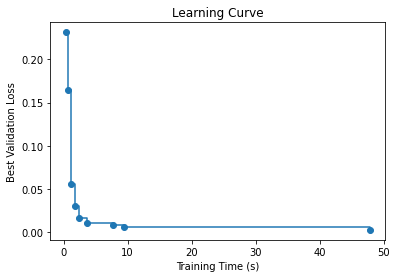

In [103]:
np.random.seed(10)  # To make sure same code will get the same output from FLAML

automl30 = AutoML()

settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": 'accuracy', 
    "task": 'multi',  # multiclass classification
    "n_splits": 5,
    "estimator_list": ['my_lgbm'],
    "split_type": 'stratified',
    "verbose": 0,
    "hpo_method": 'cfo',
    "log_file_name": 'logs/automl_specified_space_cfo_leaf30.log',  # flaml log file
}

automl30.add_learner(learner_name='my_lgbm', learner_class=my_lgbm)
automl30.fit(X_train=X_train30, y_train=y_train30, **settings)


print('Selected Estimator:', automl30.model.estimator)
print('Best loss on validation data: {0:.4g}'.format(automl30.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl30.best_config_train_time))
print()

y_pred30 = automl30.predict(X_test30)
balanced_accuracy = balanced_accuracy_score(y_test30, y_pred30)
print(f'The balanced accuracy on testing data from optimized model is {balanced_accuracy}')

# save the optimized automl object
with open('trained_models/automl_specified_space_cfo_leaf30.pkl', 'wb') as f:
    pickle.dump(automl30, f, pickle.HIGHEST_PROTOCOL)
    
    
# plot FLAML learning curve
training_time_list, best_error_list, error_list, config_list, logged_metric_list = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=60)

plot_learning_curve(training_time_list, best_error_list)

### Blend Search

You passed a `space` parameter to OptunaSearch that contained unresolved search space definitions. OptunaSearch should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `config` argument to `tune.run()` instead.
[I 2021-08-14 19:38:23,560] A new study created in memory with name: optuna


Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 5 iterations
Finished loading model, total used 11 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 6 iterations
Finished loading model, total used 8 iterations
Finished loading model, total used 5 iterations
Finished loading model, total used 15 iterations
Finished loading model, total used 6 iterations
Finished loading model, total used 14 iterations
Finished loading model, total used 16 iterations
Finished loading model, total used 24 iterations
Finished loading model, total used 9 iterations
Finished loading model, total used 8 iterations
Finished loading model, total used 28 iterations
Finished loading model, total used 22 iterations
Finished loading model, total use

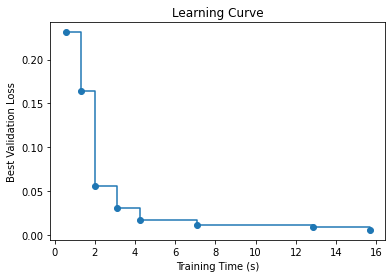

In [98]:
np.random.seed(10)  # To make sure same code will get the same output from FLAML

automl30 = AutoML()

settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": 'accuracy', 
    "task": 'multi',  # multiclass classification
    "n_splits": 5,
    "estimator_list": ['my_lgbm'],
    "split_type": 'stratified',
    "verbose": 0,
    "hpo_method": 'bs',
    "log_file_name": 'logs/automl_specified_space_bs_leaf30.log',  # flaml log file
}

automl30.add_learner(learner_name='my_lgbm', learner_class=my_lgbm)
automl30.fit(X_train=X_train30, y_train=y_train30, **settings)


print('Selected Estimator:', automl30.model.estimator)
print('Best loss on validation data: {0:.4g}'.format(automl30.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl30.best_config_train_time))
print()

y_pred30 = automl30.predict(X_test30)
balanced_accuracy = balanced_accuracy_score(y_test30, y_pred30)
print(f'The balanced accuracy on testing data from optimized model is {balanced_accuracy}')

# save the optimized automl object
with open('trained_models/automl_specified_space_bs_leaf30.pkl', 'wb') as f:
    pickle.dump(automl30, f, pickle.HIGHEST_PROTOCOL)
    
    
# plot FLAML learning curve
training_time_list, best_error_list, error_list, config_list, logged_metric_list = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=60)

plot_learning_curve(training_time_list, best_error_list)